# Making an xG Model

Using logistic regression to create an xG model using the Statsbomb open data.

Start by importing necessary packages and some data.

In [259]:
from importing_sb import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline

data_dir = '/Users/jm533/Documents/GitHub/football_analytics/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

Getting the event data for all La Liga seasons.

In [2]:
years = list(range(2015,2003,-1))
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [3]:
event_data = {}
for year in years:
    event_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(open_data(data_dir + 'events/{}.json'.format(str(match))))

Using my get_shots function to get shot DataFrames.

In [4]:
shots = {}
for year in years:
    shots[str(year)] = [get_shots(match) for match in event_data[str(year)]]

In [5]:
shots_all_list = []
for year in years:
    shots_all_list.append(pd.concat(shots[str(year)]))

Make a single DataFrame for all shots for all La Liga seasons.

In [107]:
shots_all = pd.concat(shots_all_list)
shots_all.reset_index(inplace=True)
# There are so few times when a shot follows a dribble! Will remove from data set
shots_all.drop(['follows_dribble'],axis=1,inplace=True)

## Preparing data for xG model

Sort the shot data such as removing deflections and open goals, only keeping 'Normal' technique, etc.

In [266]:
shots_all_simple = shots_all[(shots_all['open_goal'] == False)&(shots_all['deflection'] == False)
                             &(shots_all['technique'] == 'Normal')
                             &(shots_all['body_part'] != 'Head')&(shots_all['body_part'] != 'Other')
                             &(shots_all['shot_type'] == 'Open Play')&(shots_all['outcome'] != 'Blocked')]

shots_all_ref = shots_all[(shots_all['open_goal'] == False)&(shots_all['deflection'] == False)
                             &(shots_all['technique'] == 'Normal')
                             &(shots_all['body_part'] != 'Other')
                             &(shots_all['shot_type'] != 'Corner')&(shots_all['outcome'] != 'Blocked')
                             &(shots_all['play_pattern'] != 'From Goal Kick')
                             &(shots_all['play_pattern'] != 'From Kick Off')
                             &(shots_all['play_pattern'] != 'From Keeper')]

Convert x and y coords into distance from goal and angle to goal. For simplicity I have just so far taken the position of the goal to be the centre, that is x=120, y=40.

In [271]:
x2 = 120
y2 = 40
x1 = shots_all_ref['x'].values
y1 = shots_all_ref['y'].values

d = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
ang = np.arctan(np.absolute((y2-y1))/np.absolute((x2-x1)))*(180/np.pi)

Create the model DataFrame which converts False and True to 0 and 1 and collects all the predictors considered.

In [368]:
shots_model = pd.DataFrame()
shots_model['isGoal'] = (shots_all_ref['outcome'] == 'Goal').astype('int').reset_index(drop=True)
shots_model['dist'] = d
shots_model['angle'] = ang
shots_model['isHead'] = (shots_all_ref['body_part'] == 'Head').astype('int').reset_index(drop=True)
shots_model['isFirstTime'] = shots_all_ref['first_time'].astype('int').reset_index(drop=True)
shots_model['isUnderPress'] = shots_all_ref['under_pressure'].astype('int').reset_index(drop=True)
shots_model['isFK'] = (shots_all_ref['shot_type'] == 'Free Kick').astype('int').reset_index(drop=True)
shots_model['isPen'] = (shots_all_ref['shot_type'] == 'Penalty').astype('int').reset_index(drop=True)
#shots_model['isFromReg'] = (shots_all_ref['play_pattern'] == 'Regular Play').astype('int').reset_index(drop=True)
#shots_model['isFromFK'] = (shots_all_ref['play_pattern'] == 'From Free Kick').astype('int').reset_index(drop=True)
#shots_model['isFromThrow'] = (shots_all_ref['play_pattern'] == 'From Throw In').astype('int').reset_index(drop=True)
shots_model['isFromCorner'] = (shots_all_ref['play_pattern'] == 'From Corner').astype('int').reset_index(drop=True)
shots_model['isFromCounter'] = (shots_all_ref['play_pattern'] == 'From Counter').astype('int').reset_index(drop=True)

Use the statsmodels package to perform logistic regression to find the xG model.

In [369]:
X = shots_model[['dist','angle','isHead','isFirstTime','isUnderPress','isFK','isPen','isFromCorner','isFromCounter']]
y = shots_model['isGoal'].values
model = sm.Logit(y,X)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.372383
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.166      
Dependent Variable: y                AIC:              3652.4572  
Date:               2020-02-25 10:43 BIC:              3710.8933  
No. Observations:   4880             Log-Likelihood:   -1817.2    
Df Model:           8                LL-Null:          -2178.8    
Df Residuals:       4871             LLR p-value:      7.6171e-151
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
dist              -0.0936   0.0043 -21.8698 0.0000 -0.1020 -0.0852
angle             -0.0055   0.0019  -2.9021 0.0037 -0

All the coefficients have low p-values (although isUnderPress is very close to the boundary) and their signs make logical sense.

Calculate the variance inflation factor (VIF) to look for any collinearity in the coeffs. All seems fine.

In [274]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X['intercept'] = 1 # Have to add an intercept column
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,dist,1.691481
1,angle,1.189476
2,isHead,1.954213
3,isFirstTime,1.213349
4,isUnderPress,1.154796
5,isFK,1.189280
6,isPen,1.178720
7,isFromCorner,1.234182
8,isFromCounter,1.034382
9,intercept,19.179705


Now use sklearn to perform logistic regression on a train (70%) and test (30%) data set, creating the xG model.

In [370]:
reg = skl_lm.LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

/Users/jm533/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.855191256830601

The confusion matrix showing the predictions of the model.

In [371]:
pred = reg.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred)
print(conf_matrix)

[[1189   27]
 [ 185   63]]


Finding ROC curce and the corresponding AUC score to assess the classifier.

In [372]:
pred_prob = reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
auc_score = roc_auc_score(y_test,pred_prob)
print(auc_score)

0.7931080220713073


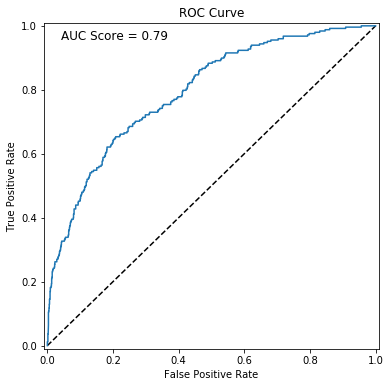

In [373]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot([0,1],[0,1],'k--')
ax.plot(fpr,tpr)

ax.set(xlim=(-0.01,1.01),ylim=(-0.01,1.01),xlabel='False Positive Rate',ylabel='True Positive Rate',title='ROC Curve')
ax.text(0.05,0.95,'AUC Score = {:.2f}'.format(auc_score),transform=ax.transAxes,fontsize=12)

plt.show()

## Comparing to Statsbomb xG

Comparing my xG model to the values calculated by Statsbomb's model, starting with each of Messi's shot in the 15/16 season.

In [627]:
shots_all_15 = pd.concat(shots['2015'])
shots_barca_15 = shots_all_15[shots_all_15['team'] == 'Barcelona']
barca_players = shots_barca_15.player.unique()

Defining a function to take a DataFrame of shots and return the correct forms for use in my xG model.

In [628]:
def get_xg_params(df):
    df = df
    
    df_clean = df[(df['open_goal'] == False)&(df['deflection'] == False)
                  &(df['technique'] == 'Normal')&(df['body_part'] != 'Other')
                  &(df['shot_type'] != 'Corner')&(df['outcome'] != 'Blocked')
                  &(df['play_pattern'] != 'From Goal Kick')&(df['play_pattern'] != 'From Kick Off')
                  &(df['play_pattern'] != 'From Keeper')]
    
    x2 = 120
    y2 = 40
    x1 = df_clean['x'].values
    y1 = df_clean['y'].values

    d = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
    ang = np.arctan(np.absolute((y2-y1))/np.absolute((x2-x1)))*(180/np.pi)
    
    shots_model = pd.DataFrame()
    shots_model['isGoal'] = (df_clean['outcome'] == 'Goal').astype('int').reset_index(drop=True)
    shots_model['dist'] = d
    shots_model['angle'] = ang
    shots_model['isHead'] = (df_clean['body_part'] == 'Head').astype('int').reset_index(drop=True)
    shots_model['isFirstTime'] = df_clean['first_time'].astype('int').reset_index(drop=True)
    shots_model['isUnderPress'] = df_clean['under_pressure'].astype('int').reset_index(drop=True)
    shots_model['isFK'] = (df_clean['shot_type'] == 'Free Kick').astype('int').reset_index(drop=True)
    shots_model['isPen'] = (df_clean['shot_type'] == 'Penalty').astype('int').reset_index(drop=True)
    shots_model['isFromCorner'] = (df_clean['play_pattern'] == 'From Corner').astype('int').reset_index(drop=True)
    shots_model['isFromCounter'] = (df_clean['play_pattern'] == 'From Counter').astype('int').reset_index(drop=True)
    
    X = shots_model[['dist','angle','isHead','isFirstTime','isUnderPress','isFK','isPen','isFromCorner','isFromCounter']]
    y = shots_model['isGoal'].values
    sb_xg = df_clean.sb_xg.values
    
    return X, y, sb_xg

In [629]:
testx, testy, sb_xg_test = get_xg_params(shots_barca_15[shots_barca_15['player'] == barca_players[1]])

The shot at index 48 is a penalty by the x and y coords are incorrect so this causes issues with my xG model. I should really introduce a system where a penalty is automatically given xG=0.76 rather than calculating using the regression. Until this is done however, just be aware of this point.

In [630]:
testx.loc[48];

In [631]:
xg_model = reg.predict_proba(testx)[:,1]

In [632]:
# Just an array to put my and Statsbomb xG side by side
xg_comp_list = []
for i in range(len(xg_model)):
    xg_comp_list.append([xg_model[i],sb_xg_test[i]])
np.array(xg_comp_list);

Making two linear fits, without and with an intercept, for my and Statsbomb xG values.

In [633]:
from statsmodels.tools import add_constant

lin_fit = sm.OLS(sb_xg_test, xg_model)
lin_fit_res = lin_fit.fit()
print(lin_fit_res.summary())

# Adding constant to linear model
xg_model_inter = add_constant(xg_model)
lin_fit_inter = sm.OLS(sb_xg_test, xg_model_inter)
lin_fit_res_inter = lin_fit_inter.fit()
print(lin_fit_res_inter.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.814
Model:                            OLS   Adj. R-squared (uncentered):              0.812
Method:                 Least Squares   F-statistic:                              402.0
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                    2.43e-35
Time:                        13:13:50   Log-Likelihood:                          62.980
No. Observations:                  93   AIC:                                     -124.0
Df Residuals:                      92   BIC:                                     -121.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

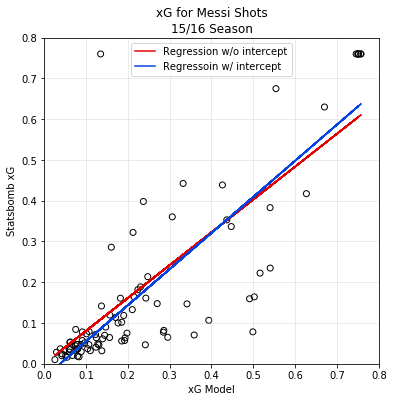

In [648]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(xg_model,sb_xg_test,facecolor='none',edgecolor='k')
ax.plot(xg_model, lin_fit_res.fittedvalues,'xkcd:red',label='Regression w/o intercept')
ax.plot(xg_model, lin_fit_res_inter.fittedvalues,'xkcd:blue',label='Regressoin w/ intercept')

ax.set(xlim=(0,0.8),ylim=(0,0.8),xlabel='xG Model',ylabel='Statsbomb xG',title='xG for Messi Shots\n15/16 Season')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.show()

### Looking at xG sums for season instead

It is probably more appropriate to look a the sum of xG over a season for each player, rather than the individual shots.

Start by calculating the xG sums.

In [623]:
sb_xg_sum = []
xg_model_sum = []
for player in barca_players:
    X, y, sb_xg = get_xg_params(shots_barca_15[shots_barca_15['player'] == str(player)])
    if len(X) > 0:
        xg_model = reg.predict_proba(X)[:,1]
        sb_xg_sum.append(sum(sb_xg))
        xg_model_sum.append(sum(xg_model))
    else:
        sb_xg_sum.append(0)
        xg_model_sum.append(0)        

sb_xg_sum = np.array(sb_xg_sum)
xg_model_sum = np.array(xg_model_sum)

Again performing linear fits with and without intercept. R^2 are now much closer to 1.

In [624]:
from statsmodels.tools import add_constant

lin_fit = sm.OLS(sb_xg_sum, xg_model_sum)
lin_fit_res = lin_fit.fit()
print(lin_fit_res.summary())

# Adding constant to linear model
xg_model_sum_inter = add_constant(xg_model_sum)
lin_fit_inter = sm.OLS(sb_xg_sum, xg_model_sum_inter)
lin_fit_res_inter = lin_fit_inter.fit()
print(lin_fit_res_inter.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1151.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                    1.81e-18
Time:                        13:12:56   Log-Likelihood:                         -24.097
No. Observations:                  20   AIC:                                      50.19
Df Residuals:                      19   BIC:                                      51.19
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

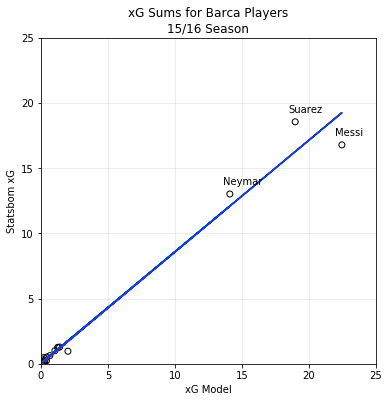

In [625]:
top_players = ['Lionel Andrés Messi Cuccittini','Luis Alberto Suárez Díaz','Neymar da Silva Santos Junior']
nicknames = ['Messi','Suarez','Neymar']
top_players_loc = []
for i in top_players:
    top_players_loc.append(np.where(barca_players == str(i))[0][0])

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(xg_model_sum,sb_xg_sum,facecolor='none',edgecolor='k')
ax.plot(xg_model_sum, lin_fit_res.fittedvalues,'xkcd:red')
ax.plot(xg_model_sum, lin_fit_res_inter.fittedvalues,'xkcd:blue')

ax.set(xlim=(0,25),ylim=(0,25),xlabel='xG Model',ylabel='Statsbomb xG',title='xG Sums for Barca Players\n15/16 Season')
ax.grid(alpha=0.3)

for i in range(len(top_players_loc)):
    ax.text(xg_model_sum[top_players_loc[i]]-0.5,sb_xg_sum[top_players_loc[i]]+0.7,nicknames[i])

plt.show()

## Comparing to actual goals